In [2]:
import os, sys
from pathlib import Path

import pandas as pd 
import dask.dataframe as dd

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

import hashlib  
import ipaddress
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


##### FUNC ############
def ip_to_float(ip):
    try:
        return float(int(ipaddress.IPv4Address(ip)))/1e9
    except:
        return 0.0  # for invalid or empty IPs
    
def sum_of_squares(partition):
    return pd.Series([(partition ** 2).sum()])

def string_to_float(s):
    if pd.notna(s):
        return int(hashlib.sha256(str(s).encode('utf-8')).hexdigest(), 16) % 10**8 / 1e8
    return 0


def down_ratio(f):
    return f/(f+1e-9)
##### FUNC ##############

In [3]:
input = "C:/Users/hoang/Documents/Dataset_KLTN/gotham2025_extracted_1.1/gotham2025_unproc_merged.csv"


df = pd.read_csv(input)

In [4]:
df.drop_duplicates()
df.dropna()
# Thay thế giá trị lỗi / thiếu 
df = df[df["Label"].notna()]
df.replace([np.inf, -np.inf, "inf", "-inf", "Infinity", "-Infinity"], np.nan, inplace=True)
df.fillna(0, inplace=True)
num_cols = df.select_dtypes(include=[np.number]).columns
label_mapping = {}

un_num_labels = df['Label'].unique()
for index, label in enumerate(un_num_labels):
    label_mapping[label]= index
print(label_mapping)
df = shuffle(df, random_state=42).reset_index(drop=True)
df["Label"] = df["Label"].map(label_mapping).fillna(-1).astype(int)

{'NeedManualLabel': 0}


In [ ]:
print(df.dtypes)

print(df.head(30))
print(df.tail())

Flow ID                        object
Src IP                         object
Src Port                        int64
Dst IP                         object
Dst Port                        int64
Protocol                        int64
Timestamp                      object
Flow Duration                   int64
Total Fwd Packet                int64
Total Bwd packets               int64
Total Length of Fwd Packet    float64
Total Length of Bwd Packet    float64
Fwd Packet Length Max         float64
Fwd Packet Length Min         float64
Fwd Packet Length Mean        float64
Fwd Packet Length Std         float64
Bwd Packet Length Max         float64
Bwd Packet Length Min         float64
Bwd Packet Length Mean        float64
Bwd Packet Length Std         float64
Flow Bytes/s                  float64
Flow Packets/s                float64
Flow IAT Mean                 float64
Flow IAT Std                  float64
Flow IAT Max                  float64
Flow IAT Min                  float64
Fwd IAT Tota

In [6]:
for col in df.columns:
    print(df[col].describe())
    print("\n")

count                    636467
unique                   433577
top       8.6.0.1-8.0.6.4-0-0-0
freq                      33303
Name: Flow ID, dtype: object


count            636467
unique               79
top       192.168.17.10
freq             422915
Name: Src IP, dtype: object


count    636467.000000
mean      28647.088212
std       19732.540558
min           0.000000
25%        9644.000000
50%       27428.000000
75%       45319.000000
max       65535.000000
Name: Src Port, dtype: float64


count            636467
unique             3066
top       192.168.18.10
freq             418334
Name: Dst IP, dtype: object


count    636467.000000
mean      21409.093804
std       20184.395763
min           0.000000
25%        3563.000000
50%       14041.000000
75%       36809.500000
max       65535.000000
Name: Dst Port, dtype: float64


count    636467.000000
mean          7.773704
std           4.676879
min           0.000000
25%           6.000000
50%           6.000000
75%           6.0

In [7]:
cols_to_drop = ["Timestamp"]
df.drop(cols_to_drop, axis=1)

# Bucket port
def bucket_port(port):
    if port < 1024:
        return 0  # Well-known
    elif port < 49152:
        return 1  # Registered
    else:
        return 2  # Dynamic/private

# Bucket
df["Src Port"] = df["Src Port"].apply(bucket_port)
df["Dst Port"] = df["Dst Port"].apply(bucket_port)

#hashing
df['Flow ID'] = df['Flow ID'].apply(string_to_float)

# ipv4 to int
df['Src IP'] = df['Src IP'].apply(ip_to_float)
df['Dst IP'] = df['Dst IP'].apply(ip_to_float)

#down / up ratio
df['TotLen Fwd Pkts'] = df['TotLen Fwd Pkts'].apply(down_ratio)

# replace - mask
for col in ['Init Fwd Win Byts','Init Bwd Win Byts']:
    df[col] = df[col].mask(df[col] < 0, 0)

# Giới hạn cực đại cho các cột numeric
# for col in num_cols:
#     df[col] = np.where(df[col] > 1e12, np.nan, df[col])

# Log-scale cho cột nghiêng mạnh
# Nhóm cột thời gian / tốc độ
# Cột	Mô tả	Gợi ý xử lý
# Flow Duration, Flow IAT Mean, Idle Mean, Active Mean...	thời lượng	→ log-scale hoặc MinMax normalization
# Flow Byts/s, Flow Pkts/s, Bwd Pkts/s	tốc độ	→ log-scale để giảm lệch
# IAT Max/Min/Std	khoảng cách giữa packet	→ log-scale + clip giá trị outlier
skew_cols = [c for c in num_cols if (("Pkt" or "Byts/s" or "Duration" or "IAT" or "Subflow" or "Header Len" or 
                                     "Down/Up Ratio" in c) and c != "Init Bwd Win Byts")]
for col in skew_cols:
    df[col] = np.log1p(df[col])
cols = ['Flow IAT Min', 'Fwd IAT Min', 'Init Bwd Win Byts']
print(df[cols].describe())

# Nhóm cột kích thước gói (Packet length)
# TotLen Fwd/Bwd Pkts, Pkt Len Mean/Max/Min/Std	log-scale hoặc StandardScaler
# Pkt Len Var	clip outlier (vd: 99th percentile)
for col in df.columns:
    if "Pkt Len" in col or "TotLen" in col:
        df[col] = np.clip(df[col], 0, df[col].quantile(0.99))
        df[col] = np.log1p(df[col])


# Chuẩn hóa toàn bộ numeric bằng StandardScaler
scaler = StandardScaler()
# num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = scaler.fit_transform(df[num_cols])


# Bỏ các cột flag toàn 0
flag_cols = [c for c in df.columns if "Flag" in c]
for c in flag_cols:
    if df[c].nunique() == 1:
        df.drop(columns=[c], inplace=True)

KeyError: 'TotLen Fwd Pkts'

In [ ]:
mask = ~np.isfinite(df.select_dtypes(include=[np.number]))
problem_cols = mask.any()[mask.any()].index
print("⚠️ Cột chứa inf hoặc quá lớn:", problem_cols.tolist())

⚠️ Cột chứa inf hoặc quá lớn: ['Flow IAT Min', 'Fwd IAT Min']


In [ ]:
output = "C:/Users/hoang/Documents/Dataset_KLTN/gotham2025_extracted_1.1/gotham2025_proced_merged.csv"
df.to_csv(output, index=False)

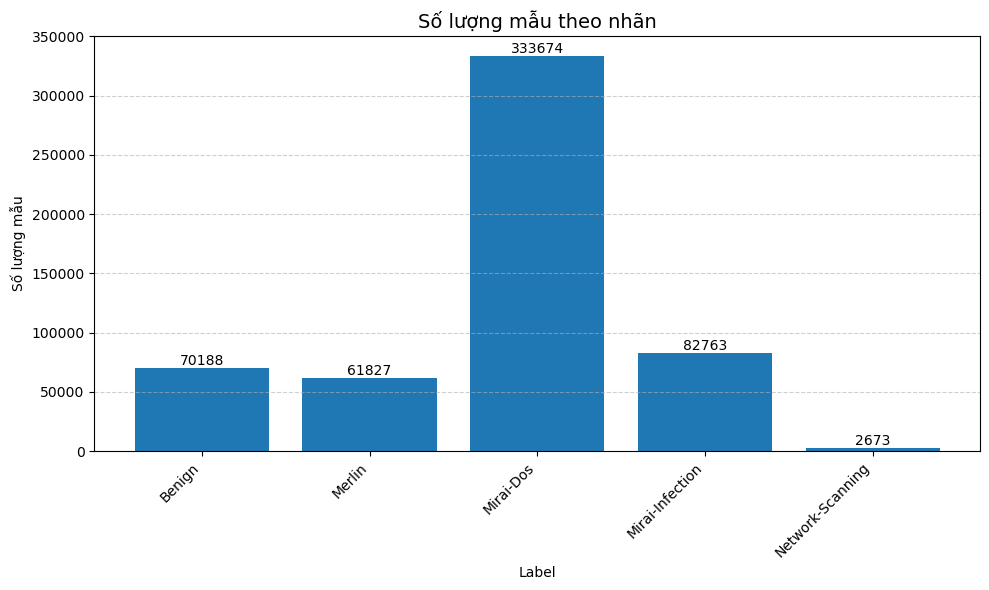

In [ ]:
import matplotlib.pyplot as plt
# Đảo ngược lại mapping: từ số -> tên
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Đếm số lượng
counts = df["Label"].value_counts().sort_index()

# Lấy tên hiển thị tương ứng
labels = [inv_label_mapping.get(idx, idx) for idx in counts.index]

# Vẽ
plt.figure(figsize=(10,6))
bars = plt.bar(labels, counts.values)

plt.title("Số lượng mẫu theo nhãn", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Số lượng mẫu")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
print(len(df.columns))

78


In [ ]:
dask_fl = dd.read_parquet("C:/Users/hoang/Documents/Dataset_KLTN/scaled_output_parquet")

print(dask_fl.head())

for col in dask_fl.columns:
    print(col)
    
print("\n\n")

for col in df.columns:
    print(col)

   flow_duration  Header_Length  Protocol Type  Duration       Rate  \
0      -0.043351      -0.378067       1.944402 -0.340584  19.321910   
1      -0.043351      -0.378067       1.914890 -0.361896  -0.082432   
2      -0.043351      -0.378067       1.915518 -0.340584  -0.082622   
3       0.010219       4.324545      -0.630113  0.655076  -0.081388   
4      -0.041905       0.750059       0.060611 -0.340584  -0.054519   

       Srate     Drate  fin_flag_number  syn_flag_number  rst_flag_number  \
0  19.321910 -0.001064        -0.243225        -0.354776        -0.255542   
1  -0.082432 -0.001064        -0.243225        -0.354776        -0.255542   
2  -0.082622 -0.001064        -0.243225        -0.354776        -0.255542   
3  -0.081388 -0.001064        -0.243225        -0.354776        -0.255542   
4  -0.054519 -0.001064        -0.243225        -0.354776        -0.255542   

   psh_flag_number  ack_flag_number  ece_flag_number  cwr_flag_number  \
0        -0.259995        -0.537575  